# Miranda (2000) for firm soils


##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). Please provide the location of the folder containing this input using the parameter `input_folder`.

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Sa-Sd.csv'
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
#utils.plot_capacity_curves(capacity_curves)

## Load ground motion records


In [2]:
gmrs_folder = '../../../../../../rmtk_data/accelerograms'
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2
#utils.plot_response_spectra(gmrs,minT,maxT)

##Calculate fragility function


5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
55%
60%
65%
70%
75%
80%
85%
90%
95%
100%


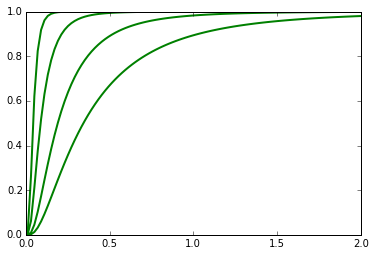

In [3]:
import miranda_2000_firm_soils

damage_model = utils.read_damage_model('../../../../../../rmtk_data/damage_model.csv')
damping = 0.05

regression_method = 'least squares'
T = 2.0
PDM, Sds = miranda_2000_firm_soils.calculate_fragility(capacity_curves,gmrs,damage_model,damping)
fragility_model = utils.calculate_mean_fragility(gmrs,PDM,T,damping,'Sa',damage_model,regression_method)
utils.plot_fragility_model(fragility_model,0.01,2)

In [4]:
print PDM

[[  0.   1.   3.  10.   6.]
 [  1.   2.   8.   4.   5.]
 [  4.  14.   2.   0.   0.]
 [ 20.   0.   0.   0.   0.]
 [  0.   1.   1.  12.   6.]
 [ 17.   3.   0.   0.   0.]
 [  0.   4.  12.   2.   2.]
 [  0.   1.   4.   8.   7.]
 [  0.   1.   5.   6.   8.]
 [  2.  11.   6.   0.   1.]
 [  0.   2.   8.   5.   5.]
 [  0.   1.   0.   9.  10.]
 [  0.   3.  12.   1.   4.]
 [  0.   4.  12.   2.   2.]
 [  2.   8.   7.   3.   0.]
 [  2.  10.   7.   1.   0.]
 [  2.   6.  10.   2.   0.]
 [ 20.   0.   0.   0.   0.]
 [  0.   2.   6.   3.   9.]
 [  2.  11.   5.   2.   0.]
 [ 14.   5.   1.   0.   0.]
 [  0.   3.   9.   4.   4.]
 [ 18.   2.   0.   0.   0.]
 [ 15.   5.   0.   0.   0.]
 [ 18.   2.   0.   0.   0.]
 [  8.   8.   4.   0.   0.]
 [  0.   3.   9.   4.   4.]
 [  3.   4.   9.   2.   2.]
 [  3.   7.   8.   2.   0.]
 [  0.   1.   2.  10.   7.]
 [ 19.   1.   0.   0.   0.]
 [ 19.   1.   0.   0.   0.]
 [  4.  15.   1.   0.   0.]
 [ 20.   0.   0.   0.   0.]
 [  7.  12.   1.   0.   0.]
 [  1.   3.   7.   6